### Práctica FINAL. MODELOS SUPERVISADOS

---

JAIME DE CECILIO Y ALFONSO ROMÁN ROVIRA. 4ºE

Machine learning modelo supervisado con Python. Se ha seleccionado la base de datos de los accidentes de coche en canada con la finalidad de realzar un modelo predictivo.

Se busca dar respuesta a las siguientes preguntas planteadas: 

- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción   correctiva en prima)?

- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?

- ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?

- Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas. 

- Libertad para generar análisis de valor y nuevas ideas. Se debe atacar mínimo un modelo (estimar si habrá fallecidos o no). Hecho esto, se puede plantear de forma opcional otros alcances (libertad para plantear opciones). 

Plus: complementar con datos abiertos de clima (aunque Canadá es muy grande) y de otra tipología, ¿hay algún tipo de relación con temperaturas medias, precipitación media del día/mes, nieve...? ¿a más días festivos o de vacaciones, más accidentes? etc. 

#### Entrega

Hay que realizar la práctica en Python y subirla en un repositorio a Github. No basta con subir el código; hay que explicar lo que se ha hecho de forma suficientemente detallada, preferiblemente con gráficas. La estructura del proyecto es indiferente, puede ser en un archivo .py o en cuadernos de Jupyter .ipynb.

Es necesario además realizar un informe en forma de diapositivas o notebook (explicado, no sólo con código y resultados) sobre el proceso realizado y los resultados para su presentación si fuera requerida.

In [ ]:
#Librerias con las que vamos a trabajar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

import multiprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib.figure import Figure
from sklearn.linear_model import LogisticRegression
import warnings

warnings.filterwarnings('ignore')

Aseguradora detección de siniestro (problema de clasificación):


In [47]:
#Cargamos los datos y los visualizamos

dataframe = pd.read_csv("/Users/jaime2/Desktop/CUNEF/MASTER_DDSS/DATA/SUPERVISADOS/ACCIDENTS/NCDB_1999_to_2014.csv")

#Head
dataframe.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,3,03,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,3,03,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,3,03,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,6,18,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,6,18,99,NN,NNNN,01,M,05,99,2,UU,3


In [48]:
#Vemos los missing con la siguiente función

def missingsummary(dataframe):
   total = dataframe.count()
   missings = dataframe.isna().sum()
   missingsummary = pd.DataFrame(index=total.index, 
                              data={'Total':total, 
                                    'Missing':missings,
                                    'Missing_rate (%)': round(missings/total * 100, 2)})
   return missingsummary
missingsummary(dataframe)

,Total,Missing,Missing_rate (%)
C_YEAR,5860405,0,0.0
C_MNTH,5860405,0,0.0
C_WDAY,5860405,0,0.0
C_HOUR,5860405,0,0.0
C_SEV,5860405,0,0.0
C_VEHS,5860402,3,0.0
C_CONF,5860405,0,0.0
C_RCFG,5860405,0,0.0
C_WTHR,5860405,0,0.0
C_RSUR,5860405,0,0.0


In [49]:
#Vemos el porcentage de cada valor de cada variable para ver sus distribuciones

col_names= dataframe.columns 
distribucionvariables={}
for i in range(len(col_names)):
    aux = dataframe.groupby(col_names[i])[["C_YEAR"]].count()
    aux ['percentage'] = 100* (aux['C_YEAR']/aux['C_YEAR'].sum())
    distribucionvariables[col_names[i]]= aux
    print(distribucionvariables[col_names[i]])

        C_YEAR  percentage
C_YEAR                    
1999    413509    7.055980
2000    422075    7.202147
2001    409389    6.985678
2002    420008    7.166877
2003    407036    6.945527
2004    389050    6.638620
2005    386470    6.594595
2006    378523    6.458990
2007    368507    6.288081
2008    338268    5.772093
2009    330771    5.644166
2010    334555    5.708735
2011    325153    5.548303
2012    322421    5.501685
2013    317058    5.410172
2014    297612    5.078352
        C_YEAR  percentage
C_MNTH                    
1       242723    4.141744
2       414025    7.064785
3       417814    7.129439
4       392533    6.698052
5       468235    7.989806
6       520010    8.873278
7       537693    9.175014
8       547045    9.334594
9       512790    8.750078
10      515911    8.803334
11      496954    8.479858
12      275451    4.700204
01      257151    4.387939
02        9262    0.158044
11        2126    0.036277
12      250297    4.270985
UU         385    0.006570
 

         C_YEAR  percentage
V_TYPE                     
01      4827390   82.372976
05        66106    1.128011
06       175491    2.994520
07        88057    1.502575
08        70556    1.203944
09        20914    0.356870
10          906    0.015460
11        51260    0.874684
14       122734    2.094292
16         9722    0.165893
17       122907    2.097244
18         3132    0.053443
19         2001    0.034144
20         7635    0.130281
21          825    0.014078
22         4583    0.078203
23         3075    0.052471
NN       227913    3.889032
QQ        25444    0.434168
UU        29754    0.507712
        C_YEAR  percentage
V_YEAR                    
1901        14    0.000239
1903         8    0.000137
1904         2    0.000034
1905         3    0.000051
1906         1    0.000017
1907         2    0.000034
1908         5    0.000085
1909         2    0.000034
1910         1    0.000017
1911         9    0.000154
1912         8    0.000137
1913         4    0.000068
1914  

         C_YEAR  percentage
P_ISEV                     
1       2375208   40.529759
2       3073431   52.444003
3         40354    0.688587
N        290711    4.960596
U         80701    1.377055
         C_YEAR  percentage
P_SAFE                     
01       198606    3.388947
02      4163903   71.051455
09        96437    1.645569
10          112    0.001911
11           11    0.000188
12        18322    0.312641
13       148730    2.537879
NN       571946    9.759496
QQ        47150    0.804552
UU       615188   10.497363
         C_YEAR  percentage
P_USER                     
1       3658827   62.433006
2       1561014   26.636623
3        219337    3.742694
4        122907    2.097244
5        122734    2.094292
U        175586    2.996141


In [50]:
print(distribucionvariables['C_MNTH'].index)

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, '01', '02', '11', '12', 'UU'], dtype='object', name='C_MNTH')


In [51]:
#Eliminamos el 01 02 11 12
dataframe['C_MNTH'] = np.where(dataframe['C_MNTH'] == "01", 1, dataframe['C_MNTH'])
dataframe['C_MNTH'] = np.where(dataframe['C_MNTH'] == "02", 2, dataframe['C_MNTH'])
dataframe['C_MNTH'] = np.where(dataframe['C_MNTH'] == "11", 1, dataframe['C_MNTH'])
dataframe['C_MNTH'] = np.where(dataframe['C_MNTH'] == "12", 1, dataframe['C_MNTH'])

print(dataframe.C_MNTH.value_counts())
meses=['C_MNTH']

1     752297
8     547045
7     537693
6     520010
10    515911
9     512790
11    496954
5     468235
2     423287
3     417814
4     392533
12    275451
UU       385
Name: C_MNTH, dtype: int64


In [52]:
print(distribucionvariables['C_WDAY'].index)

Index([1, 2, 3, 4, 5, 6, 7, '1', '2', '3', '4', '5', '6', '7', 'U'], dtype='object', name='C_WDAY')


In [53]:
#Hacemos lo mismo con los dias de la semana

dataframe['C_WDAY'] = np.where(dataframe['C_WDAY'] == '1', 1, dataframe['C_WDAY'])
dataframe['C_WDAY'] = np.where(dataframe['C_WDAY'] == '2', 2, dataframe['C_WDAY'])
dataframe['C_WDAY'] = np.where(dataframe['C_WDAY'] == '3', 3, dataframe['C_WDAY'])
dataframe['C_WDAY'] = np.where(dataframe['C_WDAY'] == '4', 4, dataframe['C_WDAY'])
dataframe['C_WDAY'] = np.where(dataframe['C_WDAY'] == '5', 5, dataframe['C_WDAY'])
dataframe['C_WDAY'] = np.where(dataframe['C_WDAY'] == '6', 6, dataframe['C_WDAY'])
dataframe['C_WDAY'] = np.where(dataframe['C_WDAY'] == '7', 7, dataframe['C_WDAY'])
print(dataframe.C_WDAY.value_counts())
meses.append('C_WDAY')

for i in range(len(meses)):
    aux = dataframe.groupby(meses[i])[["C_YEAR"]].count()
    aux ['percentage'] = 100* (aux['C_YEAR']/aux['C_YEAR'].sum())
    distribucionvariables[meses[i]]= aux
    print(distribucionvariables[meses[i]])

5    999725
4    869653
6    867188
3    825560
2    816265
1    776012
7    704679
U      1323
Name: C_WDAY, dtype: int64
        C_YEAR  percentage
C_MNTH                    
1       752297   12.836946
2       423287    7.222828
3       417814    7.129439
4       392533    6.698052
5       468235    7.989806
6       520010    8.873278
7       537693    9.175014
8       547045    9.334594
9       512790    8.750078
10      515911    8.803334
11      496954    8.479858
12      275451    4.700204
UU         385    0.006570
        C_YEAR  percentage
C_WDAY                    
1       776012   13.241610
2       816265   13.928474
3       825560   14.087081
4       869653   14.839469
5       999725   17.058975
6       867188   14.797407
7       704679   12.024408
U         1323    0.022575


2- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?



3-¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?



Text(0.5, 1.0, 'Distribución variable edad')

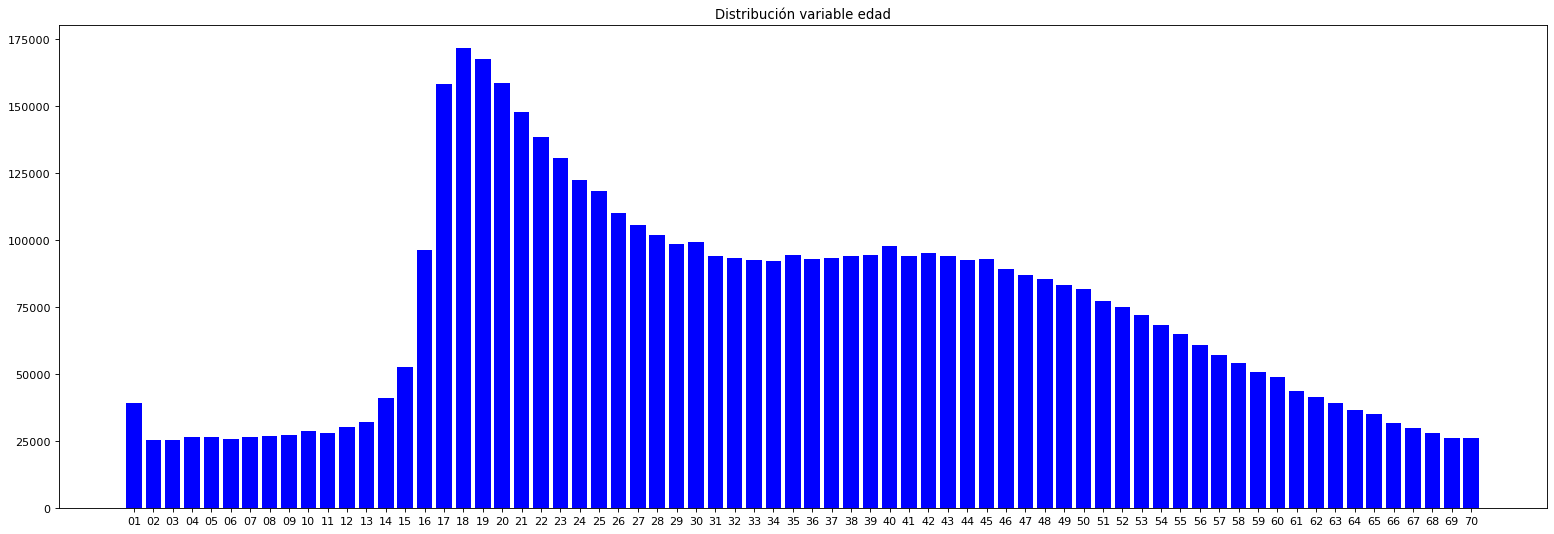

In [54]:
#Vemos las distribuciones de las variables que sean determinantes en cuanto al conductor y las visualizamos

#Edad

figure(figsize=(24,8 ), dpi=80)
plt.bar(distribucionvariables['P_AGE'].index[0:70],distribucionvariables['P_AGE']['C_YEAR'][0:70] , color='b')
plt.title("Distribución variable edad")

#Se puede observar en el gráfico siguiente que las edades que más se ven envueltas en accidentes son los 18 años, en la que por lo general aumenta
#hasta llegar a esta edad, y disminuye pasada esta edad.

Text(0.5, 1.0, 'Distribución variable genero')

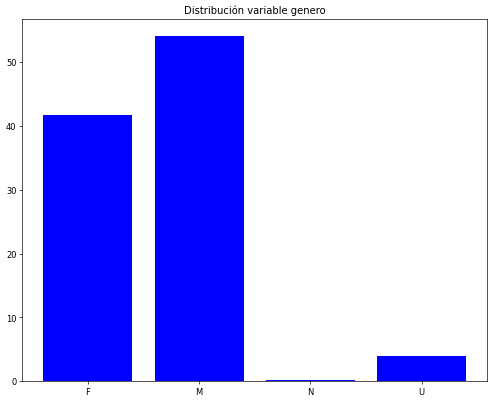

In [55]:
#Género

from matplotlib.pyplot import figure
figure(figsize=(10,8 ), dpi=60)
plt.bar(distribucionvariables['P_SEX'].index,distribucionvariables['P_SEX']['percentage'] , color='b')
plt.title("Distribución variable genero")

#Se puede observar que la mayoría de conductores son hombres

Text(0.5, 1.0, 'Distribución variable edad vehículo')

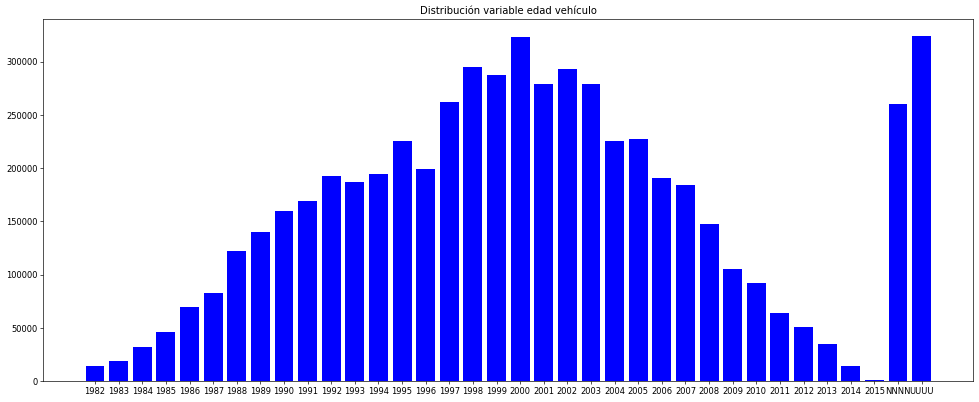

In [56]:
#Año modelo del vehículo

figure(figsize=(20,8 ), dpi=60)
plt.bar(distribucionvariables['V_YEAR'].index[80:],distribucionvariables['V_YEAR']['C_YEAR'][80:] , color='b')
plt.title("Distribución variable edad vehículo")

#En el gráfico se puede ver que los vehículos más accidentados son modelos entre los años 1998 y 2000 y próximos. Aun que también
#hay bastantes desconocidos o que no proveen esa información.

Text(0.5, 1.0, 'Distribución variable tipo de usuario')

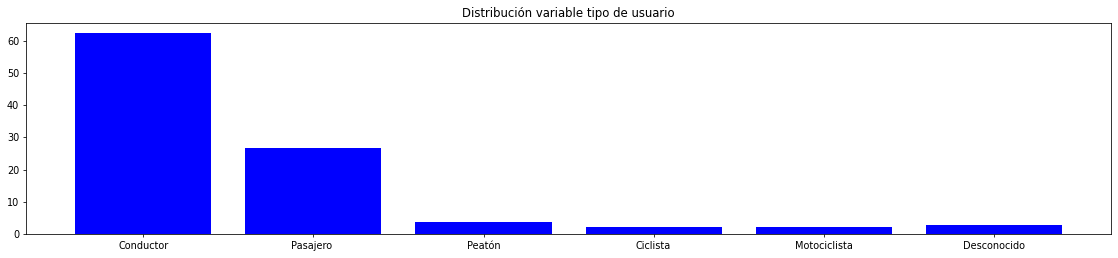

In [57]:
#Usuario accidentado

figure(figsize=(20,4 ), dpi=70)
label= ['Conductor', 'Pasajero ', 'Peatón', 'Ciclista', 'Motociclista', 'Desconocido']
plt.bar(label,distribucionvariables['P_USER']['percentage'] , color='b')
plt.title("Distribución variable tipo de usuario")

#Se ve claramente que el tipo de usuario es en mayoría el conductor, y pasajero la mitad. En mucha menor medida se encuentran los 
#peatones, cicistas y motociclistas.

Text(0.5, 1.0, 'Tipo de vehículo')

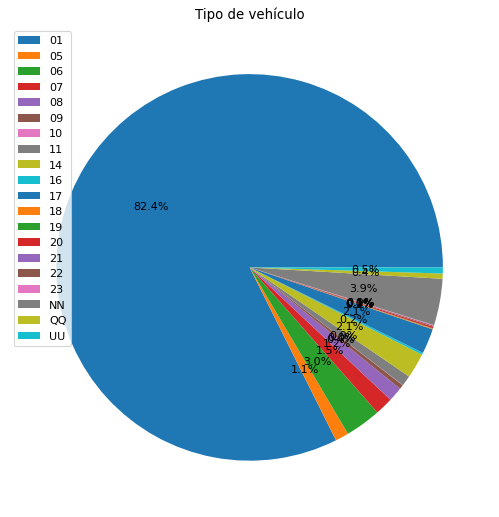

In [58]:
#Vehículo

from matplotlib.pyplot import figure

figure(figsize=(10,8 ), dpi=80)

plt.pie(distribucionvariables['V_TYPE']['C_YEAR'], autopct='%1.1f%%')
plt.legend( distribucionvariables['V_TYPE'].index, loc="best")
plt.title("Tipo de vehículo")

#Se puede observar que el 82,5% de los vehículos son Vehículo ligero (coche de pasajeros, furgoneta de pasajeros, vehículos utilitarios ligeros y 
#camionetas ligeras). 
#Los mayores del resto son Buses urbanos e Intercity, y vehículos agrícolas.

11: Conductor
12: Delante centro
13: Copiloto
21: Atrás izquierda 
22: Atrás centro 
23: Atrás derecha 
31: Tercera fila izquierda 
32: Tercera fila centro 
33: Tercera fila derecha 
96: Ocupante desconocido
97: Sentado encima de alguien
98: Pasajero fuera del coche
99: Peatón
NN: NN
QQ: QQ
UU: UU


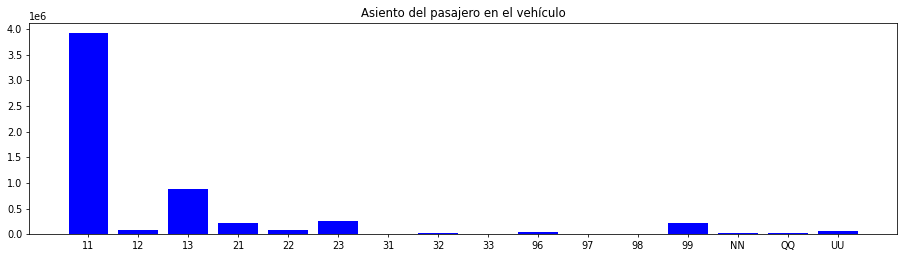

In [59]:
#Asiento en el coche

figure(figsize=(16,4 ), dpi=70)
labels= ['Conductor', 'Delante centro', 'Copiloto', 'Atrás izquierda ', 'Atrás centro ', 'Atrás derecha ', 'Tercera fila izquierda ', 'Tercera fila centro ', 'Tercera fila derecha ', 'Ocupante desconocido', 'Sentado encima de alguien', 'Pasajero fuera del coche', 'Peatón', 'NN', 'QQ', 'UU']
plt.bar(distribucionvariables['P_PSN'].index,distribucionvariables['P_PSN']['C_YEAR'] , color='b')
plt.title("Asiento del pasajero en el vehículo")
for i in range(len(labels)): 
    print(distribucionvariables['P_PSN'].index[i]+ ": "+ labels[i])

#Se puede ver como la mayoría son el conductor, como se podía esperar, y seguido por el copiloto aun que de manera alejada.

##### 2 - Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?

- Los *vehículos* más propensos a tener accidentes son los vehículos ligeros, como puede ser un turismo normal y corriente, que a pesar de tener una mayor participación, se superan en esta medida. En cuanto a la antigüedad se puede observar que los vehículos cuyo modelo tiene lugar entre los años 1995 y 2002 son los que más accidentes sufren. Esto podría explicarse debido a su mayor probabilidad de sufrir accidentes por el simple hecho de tener mayor tiempo de vida y haber sido más usados que los mas recientes, o que los antigüos que dejan de ser utilizados.

- En cuanto a los *conductores* más propensos a tener accidentes son las personas con 18 años, que se podría explicar debido a que es el año oficial para poder empezar a conducir, y esto explica claramente que los novatos tengan más accidentes que los conductores exerimentados, lo que se puede ver que cada año que pasa los accidentes por lo general se mantienen o se reducen. Los hombres suuperan ligeramente a las mujeres.

- **Por lo que habría que llevar a cabo acciones correctivas en las primas de los asegurados que tengan edades cercanas a los 18, con vehículos ligeros (turismos) fabricados entre los años 1995 y 2002.**

#### 3 - ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)? 

- En cuanto a los *conductores* menos propensos a tener accidentes serían las mujere ligeramente por debajo de los hombres, y en cuanto a la edad sería entorno a los 30 años en adelante. Cada año que pase el conductor tendrá más experiencia y puede que conduzca menos, por lo que cuanto más mayor por lo general menos accidentes.
- En cuanto a los *vehículos* menos propensos serían aquellos fabricados mas cercanos a los años 1982 y lo más nuevos. (2014 y más cercanos).
- **Por lo que por ejemplo habría que hacer descuento en las primas a las mujeres que tengan una alta edad y conduzcan vehículos nuevos o muy antigüos.**


**4-¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?**



In [60]:
#Train y test de la variable C_SEV, en la que 1 significa al menos un fallecido en el accidente y 2 ninguna.
data2, test_df = train_test_split (dataframe, test_size= 0.9, random_state=100,stratify=dataframe['C_SEV'])

In [61]:
#Convertimos la variable hora en noche (22h-6h), dia(6h-14h) y tarde(14h-22h) con la siguiente función:

def c_hour(valor):
    if valor=='UU' :
        return valor
    elif int(valor)>=22 or int(valor)<= 6 :
        return 'Noche'
    elif int(valor)>6 and int(valor)<= 14 :
        return 'Dia'
    elif int(valor)>14 and int(valor)< 22 :
        return 'Tarde'
    
data2["C_HOUR"]=data2['C_HOUR'].apply( c_hour )


In [62]:
#calculamos la antiguedad del coche 

def ant(colision, vehiculo):
    if  vehiculo == 'UUUU':
        return None
    elif vehiculo == 'NNNN':
        return None
    else: 
        return (int(colision) - int(vehiculo))
dataframe['antiguedad']=dataframe.apply( lambda x: ant(x.C_YEAR, x.V_YEAR), axis=1 )
figure(figsize=(16,8 ), dpi=80)

antiguedad = dataframe.groupby('antiguedad')[["C_YEAR"]].count()
antiguedad ['percentage'] = 100* (aux['C_YEAR']/aux['C_YEAR'].sum())
figure(figsize=(16,8 ), dpi=80)
indice= antiguedad.index[0:25].values
valor= antiguedad['C_YEAR'][0:24].values

<Figure size 1280x640 with 0 Axes>

<Figure size 1280x640 with 0 Axes>

In [63]:
#Hacemos lo mismo con vehiculo
def ant(colision, vehiculo):
    if  vehiculo == 'UUUU':
        return None
    elif vehiculo == 'NNNN':
        return None
    else: 
        return (int(colision) - int(vehiculo))
data2['antiguedad']=data2.apply( lambda x: ant(x.C_YEAR, x.V_YEAR), axis=1 )

In [64]:
#Quitamos las variables con representación muy baja para no sobrecargar el modelo en V_ID

eliminar = []
for i in distribucionvariables['V_ID'].index: 
    if distribucionvariables['V_ID'].loc[i, "percentage"]< 0.5:
        eliminar.append(i)
eliminar.remove('UU')

In [65]:
def V_ID(valor):
    if  valor in eliminar:
        return "Otro"
    else: 
        return valor
data2['V_ID']=data2.apply(lambda x: V_ID(x.V_ID), axis=1 )

In [66]:
#Quitamos las variables con representación muy baja para no sobrecargar el modelo en P_ID


eliminar = []
for i in distribucionvariables['P_ID'].index: 
    if distribucionvariables['P_ID'].loc[i, "percentage"]< 0.5:
        eliminar.append(i)
def P_ID(valor):
    if  valor in eliminar:
        return "Otro"
    else: 
        return valor
data2['P_ID']=data2.apply(lambda x: P_ID(x.P_ID), axis=1 )

In [67]:
#Convertimos la variable antiguedad creada arriba en rangos con la siguiente función:

def antiguedad(valor):
    if  valor <3:
        return "Menos de 2"
    elif  (valor >=2) and (valor<=5):
        return "Entre 2 y 5"
    elif  (valor >5) and (valor<=10):
        return "Entre 6 y 10"
    elif  (valor >10) and (valor<=15):
        return "Entre 11 y 15"
    elif  (valor >15) and (valor<=20):
        return "Entre 16 y 20"
    else: 
        return 'Mas de 20'
data2['antiguedad']=data2.apply(lambda x: antiguedad(x.antiguedad), axis=1 )

In [68]:
#Convertimos la variable edad en rangos con la siguiente función:


def P_AGE(valor):
    if valor =='NN':
        return valor
    elif valor == "UU":
        return valor
    else:
        valor = int(valor)
        if valor <=18:
            return "Menos de 18"
        elif  (valor >18) and (valor<=25):
            return "Entre 18 y 25"
        elif  (valor >25) and (valor<=40):
            return "Entre 25 y 40"
        elif  (valor >40) and (valor<=55):
            return "Entre 40 y 55"
        elif  (valor >55) and (valor<=70):
            return "Entre 55 y 70"
        elif valor>70:
            return 'Mas de 70'
        else: 
            return valor
data2['P_AGE']=data2.apply(lambda x: P_AGE(x.P_AGE), axis=1 )

In [69]:
#Quitamos las variables con representación muy baja para no sobrecargar el modelo en C_VEHS


eliminar = []
for i in distribucionvariables['C_VEHS'].index: 
    if distribucionvariables['C_VEHS'].loc[i, "percentage"]< 0.5:
        eliminar.append(i)
def C_VEHS(valor):
    if  valor in eliminar:
        return "Otro"
    else: 
        return valor
data2['C_VEHS']=data2.apply(lambda x: C_VEHS(x.C_VEHS), axis=1 )

In [70]:
data2= data2.drop("V_YEAR",axis=1)
data2 = data2.drop('C_YEAR', axis=1)
data2 = data2.astype({"C_SEV": str}, errors='raise') 

In [71]:
data2.head(5)

,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_ID,V_TYPE,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,antiguedad
4185241,10,3,Noche,2,2,35,02,3,2,2,01,2,01,01,M,Menos de 18,11,2,02,1,Entre 6 y 10
1814256,5,5,Dia,2,02,35,02,1,1,1,18,01,01,01,F,Entre 55 y 70,11,1,UU,1,Menos de 2
1861931,7,1,Dia,2,02,35,02,2,2,2,18,1,01,01,F,Entre 18 y 25,11,1,02,1,Entre 2 y 5
1260921,1,4,Dia,2,1,02,01,4,3,1,18,01,01,01,M,Entre 25 y 40,11,2,02,1,Entre 11 y 15
2312447,8,5,Tarde,2,3,21,02,1,1,1,01,03,01,01,M,Entre 40 y 55,11,1,02,1,Entre 6 y 10


**5-Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas.** 



In [72]:
data2.P_ISEV.value_counts()

2    307377
1    237233
N     29122
U      8222
3      4086
Name: P_ISEV, dtype: int64

In [73]:
#0 si no hay lesión, 2 o 3 si fallece o es herido:

def P_ISEV(valor):
    if  valor == "2" :
        return "1" 
    elif valor =="3":
        return("1")
    elif valor =='1':
        return 0
    else: 
        return valor
data2['P_ISEV']=data2.apply(lambda x: P_ISEV(x.P_ISEV), axis=1 )

In [74]:
#Quitamos los desconocidos o los que no tenemos datos

data2 = data2.drop(data2[data2.C_SEV == 'U' ].index)
data2 = data2.drop(data2[data2.C_SEV == 'X' ].index)
data2 = data2.drop(data2[data2.P_ISEV == 'U' ].index)
data2 = data2.drop(data2[data2.P_ISEV == 'X' ].index)
data2 = data2.drop(data2[data2.P_ISEV == 'N' ].index)

In [75]:
#creamos data y train y test

dummies=pd.get_dummies(data2, columns=data2.columns, drop_first=True )
train_df, test_df = train_test_split (dummies, test_size= 0.9, random_state=100)

In [76]:
train_df_fallecido=train_df.drop('P_ISEV_1', axis=1)
test_df_fallecido=test_df.drop('P_ISEV_1', axis=1)
y_train_fallecido=train_df_fallecido['C_SEV_2']
x_train_fallecido=train_df_fallecido.drop('C_SEV_2', axis=1)
y_test_fallecido=test_df_fallecido['C_SEV_2']
x_test_fallecido=test_df_fallecido.drop('C_SEV_2', axis=1)


In [77]:
#Utilizamos regresión logística

RegresionLog = LogisticRegression(random_state=100)
RegresionLog.fit(x_train_fallecido,y_train_fallecido)

LogisticRegression(random_state=100)

In [78]:
from matplotlib import pyplot
columnas=list(x_train_fallecido.columns)
peso = RegresionLog.coef_[0]
peso_data=pd.DataFrame([columnas,peso]).transpose()



In [79]:
#Vemos el peso y lo importante que es cada variable para nuestro modelo por su coeficiente

peso_data.columns = ['Variable', 'Coeficiente']
peso_data['Coeficiente']=peso_data['Coeficiente'].apply(abs)
peso_data.sort_values('Coeficiente', ascending=False)

,Variable,Coeficiente
93,C_TRAF_10,1.989765
35,C_CONF_21,1.892185
135,P_ID_05,1.675825
162,P_SAFE_02,1.577514
40,C_CONF_31,1.571592
111,V_ID_Otro,1.552217
95,C_TRAF_12,1.331272
116,V_TYPE_08,1.270244
136,P_ID_Otro,1.247632
166,P_SAFE_13,1.233890


In [80]:
#Vemos la precisión de nuestro modelo de si habra fallecidos mediante regresión logística, en el cual obtenemos una precisión del 0.98
prediccion=RegresionLog.predict(x_test_fallecido)
AcurracyRegLog = accuracy_score(y_test_fallecido,prediccion)
AcurracyRegLog

0.982615369349995

In [81]:
#MODELO INTERVENCIÓN MÉDICA 

train_df_herido=train_df.drop('C_SEV_2', axis=1)
test_df_herido=test_df.drop('C_SEV_2', axis=1)
y_train_herido=train_df_herido['P_ISEV_1']
x_train_herido=train_df_herido.drop('P_ISEV_1', axis=1)
y_test_herido=test_df_herido['P_ISEV_1']
x_test_herido=test_df_herido.drop('P_ISEV_1', axis=1)

RegresionLog2 = LogisticRegression(random_state=100)
RegresionLog2.fit(x_train_herido,y_train_herido)
prediccion_herido = RegresionLog2.predict(x_test_herido)

In [82]:
#Estudiamos su accuracy, precision, recall, f1 score, matriz de confusión y su AuC

Accuracy = accuracy_score(y_test_herido,prediccion_herido)
Precission = precision_score(y_test_herido,prediccion_herido)
Recall = recall_score(y_test_herido,prediccion_herido)
f1_score = f1_score(y_test_herido,prediccion_herido)
matrizconfusion = confusion_matrix(y_test_herido,prediccion_herido)
predictions = RegresionLog2.predict_proba(x_test_herido)[:,1]
AUC = roc_auc_score(y_test_herido, predictions)
fp_log,tp_log, x_log= roc_curve(y_test_herido, predictions)

print('Accuracy: '+str(Accuracy) )

print('Recall: '+str(Recall) )
print('Precission: '+str(f1_score) )
print('Precission: '+str(Precission) )
print('Confussion matrix: ' )
print(matrizconfusion)
print('AUC: ' + str(AUC))

Accuracy: 0.6992367772519527
Recall: 0.777591543871161
Precission: 0.7459447809420527
Precission: 0.716773228579412
Confussion matrix: 
[[127256  86159]
 [ 62366 218046]]
AUC: 0.7717986977642096


Text(0.5, 257.44, 'Predicted label')

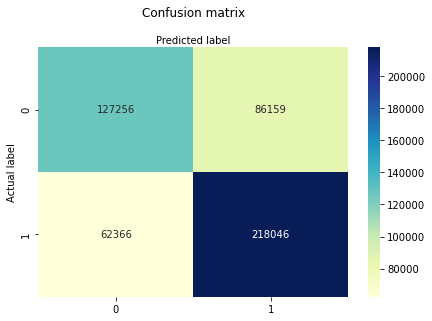

In [83]:
#Visualizamos la matriz de confusion

fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(matrizconfusion), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

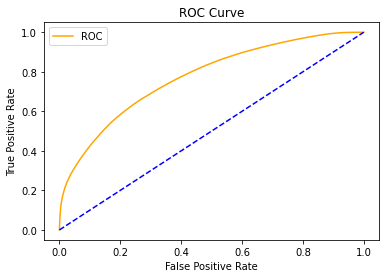

In [84]:
#Visualizamos la curva ROC y vemos el AuC

def plot_roc_curve(fp_log, tp_log):
    plt.plot(fp_log, tp_log, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="b", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
plot_roc_curve(fp_log,tp_log)

In [ ]:
### Tambien podriamos probar con random forest. 

In [ ]:
# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

**6-Libertad para generar análisis de valor y nuevas ideas. Se debe atacar mínimo un modelo (estimar si habrá fallecidos o no). Hecho esto, se puede plantear de forma opcional otros alcances (libertad para plantear opciones)**



In [ ]:
#Modelo con KNN

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=20)
model.fit(x_train_herido,y_train_herido)

predict= model.predict(x_test_herido)
print(predict)

In [ ]:
AccuracyKnn = accuracy_score(y_test_herido,predict)
PrecisionKnn = precision_score(y_test_herido,predict)
RecallKnn = recall_score(y_test_herido,predict)
ConfusionMatrixKnn = confusion_matrix(y_test_herido,predict)
PredictKnn = RegresionLog2.predict_proba(x_test_herido)[:,1]
AuC_Knn = roc_auc_score(y_test_herido, PredictKnn)
fp_log,tp_log, x_log= roc_curve(y_test_herido, PredictKnn)

print('Accuracy: '+str(AccuracyKnn) )

print('Recall: '+str(RecallKnn) )
print('Precission: '+str(PrecisionKnn) )
print('Confussion matrix: ' )
print(ConfusionMatrixKnn)
print('AUC: ' + str(AuC_Knn))

In [ ]:
#Visualizamos la matriz de confusion


fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(ConfusionMatrixKnn), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
#Visualizamos la cruva ROC y AuC

def plot_roc_curve(fp_log, tp_log):
    plt.plot(fp_log, tp_log, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="b", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
plot_roc_curve(fp_log,tp_log)

In [ ]:
#Con Arbol de decision

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

arbol = RandomForestClassifier(n_estimators=800, min_samples_split=i)

arbol.fit(x_train_herido,y_train_herido)
PrediccionArbol=arbol.predict(x_train_herido)
AccuracyArbol = accuracy_score(y_train_herido,PrediccionArbol)
    
print('Train')
print('Accuracy : '+str(AccuracyArbol) )    
PrediccionArbol=arbol.predict(x_test_herido)
AccuracyArbol = accuracy_score(y_test_herido,PrediccionArbol)
print('Test')
print('Accuracy : '+str(AccuracyArbol) )

**7-Plus: complementar con datos abiertos de clima (aunque Canadá es muy grande) y de otra tipología, ¿hay algún tipo de relación con temperaturas medias, precipitación media del día/mes, nieve...? ¿a más días festivos o de vacaciones, más accidentes? etc. ***



In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10,8 ), dpi=60)
plt.bar(distribucionvariables['C_WTHR'].index,distribucionvariables['C_WTHR']['percentage'] , color='b')
plt.title("Distribución variable tiempo")

#Se puede observar que los días con mayor accidentes son los soleados (debido a su mayor participación), seguido de 
# de los dias nublados/lluviosos/nieve de manera igualada.